In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition

In [2]:
# Training parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  128 # TODO PUT BACK TO 1500 #steps taken
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
LR_DQN = 0.01



# Environment parameters
IMSIZE = 128
STACK_SIZE = 1
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to


environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 
agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=12000,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)


optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Utilities
def process_state(state_raw):
    """ @TODO 
    - Image processing
    - Phosphene simulation
    - Frame stacking
    """
    frame = environment.state2usableArray(state_raw)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame.astype('float32')
    return torch.Tensor(frame / 255.).view(1,1,environment.size, environment.size)

In [4]:
## Some more training parameters 
MAX_EPISODES = 1e4 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
TRAINING_CONDITION = 0 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
LOGFILE = 'Out/test-04.csv'
MODEL_PATH = 'Out/test-04.pth'

# How to handle the different end signals
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:False}  # Reached step target


# Write header to logfile 
with open(LOGFILE, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['episode','step_count', 'wall_collisions', 'box_collisions' 'train_loss', 'reward'])

# Reset counters 
wall_collisions = 0
box_collisions = 0
total_reward = 0
total_loss = 0


for episode in range(int(MAX_EPISODES)):
    
    # @TODO: SAVE AFTER VALIDATION
    torch.save(agent.policy_net.state_dict(), MODEL_PATH)
    
    # Write performance to log file
    with open(LOGFILE, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([episode,agent.step_count,
                         wall_collisions, box_collisions, 
                         total_reward,total_loss]) 
    
    
    # Stop training after 
    if agent.step_count > MAX_STEPS:
        break
    
    # Target net is updated once in a few episodes (double Q-learning)
    if episode % TARGET_UPDATE == 0:  #episodes
        print('episode {}, target net updated'.format(episode))
        agent.update_target_net
    
    
    # Reset environment at start of episode
    _, _, state_raw = environment.reset(TRAINING_CONDITION)
    state = process_state(state_raw).to(DEVICE)
    
    # Episode starts here:
    for t in count(): 
        
        # 1. Agent performs a step (based on the current state) and obtains next state
        action = agent.select_action(state)
        end, reward, next_state_raw = environment.step(action.item())
        next_state = process_state(next_state_raw).to(DEVICE) if not RESET_UPON_END_SIGNAL[end] else None
        
        # 2. Interpret reward signal
        if reward > 100:
            reward = -(reward -100)
        
        # 3. Push the transition to replay memory (in the right format & shape)
        reward = torch.tensor([reward], device=DEVICE,dtype=torch.float)
        action = action.unsqueeze(0)
        agent.memory.push(state, action, next_state, reward)
        
    
        # 4. optimize model
        if len(agent.memory) > REPLAY_START_SIZE:
            
            state_action_values, expected_state_action_values = agent.forward()
            
            # Compute Huber loss
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
            total_loss += loss.item()

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(agent.policy_net.parameters(), 1)

            # Update the model parameters
            optimizer.step()
            
            """ @TODO: validation loop"""
        else:
            # Do not count as optimization loop
            agent.step_count = 0
            
        # 5. Store performance and training measures
        total_reward += reward.item();
        if end == 1:
            box_collisions += 1
        if end == 2:
            wall_collisions +=1
        
        # 6. the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
        if RESET_UPON_END_SIGNAL[end]:
            break
        else:
            state = next_state

episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
episode 300, target net updated
episode 310, target

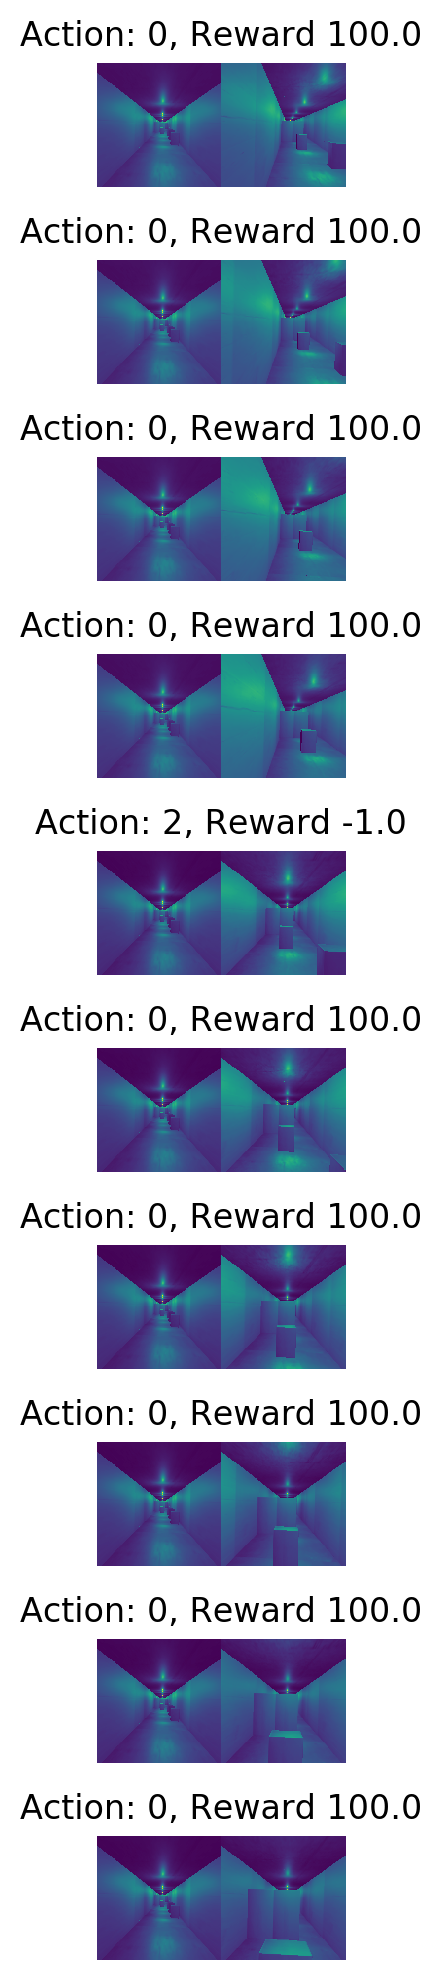

In [25]:
plt.figure(figsize = (100,10), dpi=200)
i = 0
for state, action, next_state, reward in agent.memory.memory[:10]:
    i+=1
    plt.subplot(10,1,i)
    plt.imshow(torch.cat([state,next_state],dim=3).detach().cpu().numpy().squeeze())
    plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
    plt.axis('off')
    
plt.tight_layout()
plt.show()